Go directly to:
- [**Start page**](https://github.com/m-guggenmos/remeta/)
- [**Installation**](https://github.com/m-guggenmos/remeta/blob/master/INSTALL.md)
- [**Basic Usage** (this page)](https://github.com/m-guggenmos/remeta/blob/master/demo/basic_usage.ipynb)
- [**Common use cases**](https://github.com/m-guggenmos/remeta/blob/master/demo/common_use_cases.ipynb)
- [**Exotic use cases**](https://github.com/m-guggenmos/remeta/blob/master/demo/exotic_use_cases.ipynb)

## Basic usage

In this section, the essential settings to run a ReMeta analysis are introduced.

## Basic usage

In this section, the essential settings to run a ReMeta analysis are introduced.

In [1]:
import numpy as np
import remeta
import matplotlib.pyplot as plt
np.random.seed(42)  # make notebook reproducible

To specify the model, we use the `Configuration` object:

In [2]:
cfg = remeta.Configuration()

#### Specify model architecture
The architecture of the metacognitive level is characterized by three main variables:
- Whether the dominant source of metacognitive noise applies to the level of readout (`cfg.meta_noise_type = 'noisy-readout'`) or the level of the confidence report (`cfg.meta_noise_type = 'noisy-readout'`). By default the toolbox assumes a noisy-report model.
- The metacognitive noise distribution (default: `cfg.meta_noise_dist = 'truncated_norm'`)
- The confidence link function, which specifies the transformation from evidence to confidence (default: `meta_link_function='probability_correct'`)

The following table gives an overview over possible settings:

| Setting        | Decsription                                                                                       | Default | Other values |
|:----------------|---------------------------------------------------------------------------------------------------:|-------------------------------:|:-------------------------------|
|`meta_link_function`| *Specify the function that describes the relationship between evidence and confidence*       | `'probability_correct'` | `'identity'`, `'tanh'`, `'normcdf'`, `'erf'`, `'alg'`, `'guder'`, `'linear'`, `'{x}_criteria'`, `'{x}_criteria_linear'`<br/>Note: replace {x} with the number of criteria in case of a criterion-based link function, e.g. `'3_criteria'` |
|`meta_noise_type`| _Specify whether metacognitive noise should be considered at the level of readout or report_ | `'noisy_report'`| `'noisy_readout'`| 
`meta_noise_dist` | _Specify the type of noise distribution used to model metacognitive noise_| `'truncated_norm'` | `'truncated_gumbel'`, `'truncated_lognorm'`, `'norm'`, `'gumbel'`, `'lognorm'`, `'beta'`, `'gamma'`, `'censored_norm'`, `'censored_gumbel'`, `'censored_lognorm'`, `'censored_gamma'`|


Only the default setting for the `cfg.meta_link_function` to `'probability_correct'` allows for a meaningful interpretion of metacognitive bias parameters. See below for examples of other link function choices.

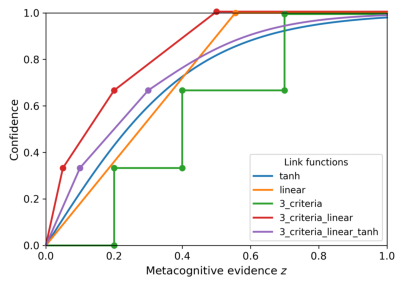

In [3]:
from matplotlib.image import imread
plt.figure(figsize=(10, 5))
plt.imshow(imread('plot_link_functions_tutorial.png'))
plt.axis('off');

See also some examples of choices for metacognitive noise:

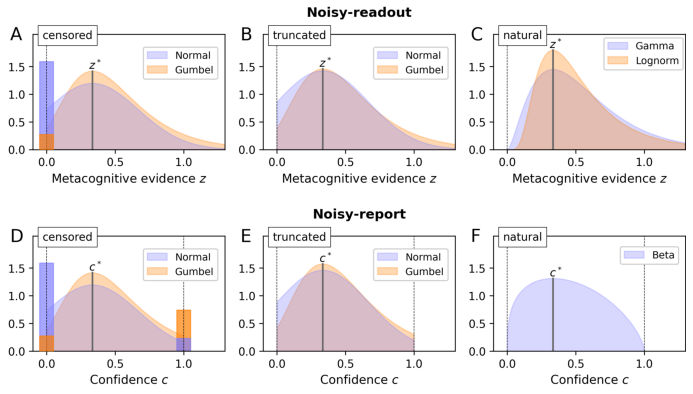

In [4]:
plt.figure(figsize=(14, 7))
plt.imshow(imread('plot_noise_models.png'))
plt.axis('off');

#### Parameter specification
In a next step, we specify the model parameters. By default, a parameter for sensory noise and metacognitive noise is enabled, as well as parameters for a sensory bias and a multiplicative metacognitive bias. Each parameter can either be disabled (`cfg.enable_XYZ = 0`), enabled (`cfg.enable_XYZ = 1`) or enabled in duplex mode (`cfg.enable_XYZ = 2`), which means that separate values are fitted depending on the sign of the stimulus (for sensory parameters) or the sign of the sensory decision value (for metacognitive parameters).

| Setting                            | Description                                                                                                                                        | Default |
|------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|---------|
| `enable_warping_sens`              | _Nonlinear transduction. The default transduction function <br/>is a power function; alternatively set `function_warping_sens`_ to `'exponential'` | `0`     |
| `enable_noise_sens`                | _Sensory noise. This should be activated in all realistic<br/>settings. If set to_ `0`, _sensory noise is set to<br/>a very small value_           | `1`     |
| `enable_thresh_sens`               | _Sensory threshold_                                                                                                                                | `0`     |
| `enable_bias_sens`                 | _Sensory bias_                                                                                                                                     | `1`     |
| `enable_noise_meta`                | _Metacognitive noise_ This should be activated in all realistic<br/>settings. If set to_ `0`, _sensory noise is set to<br/>a very small value_     | `1`     |
| `enable_evidence_bias_mult_meta`   | _Multiplicative metacognitive evidence bias_                                                                                                       | `1`     |
| `enable_evidence_bias_add_meta`    | _Additive metacognitive evidence bias_                                                                                                             | `0`     |
| `enable_confidence_bias_mult_meta` | _Multiplicative confidence bias_                                                                                                                   | `0`     |
| `enable_confidence_bias_add_meta`  | _Additive confidence bias_                                                                                                                         | `0`     |
| `enable_confidence_bias_exp_meta`  | _Exponential confidence bias_                                                                                                                      | `1`     |
| `enable_criteria_meta`             | _Enable confidence criteria (this requires<br/> a criterion-bsaed link function)_                                                                  | `0`     |
| `enable_levels_meta`               | _Enable confidence levels, i.e. variable confidence <br/>levels at each criterion (this requires a criterion-based<br/> link function)_            | `0`     |

One of the most important aspects of parameter specification is the choice of metacognitive biases parameters. By default, a single metacognitive bias is considered at the level of evidence: `enable_evidence_bias_mult_meta`. 

In general, metacognitive biases are assumed to apply either to type 1 decision values ("evidence" refers to the absolute value of decision values) or at the level of confidence. Evidence-related metacognitive bias parameters can be either conceived as a misestimation of evidence (as the name suggests) or as a misestimation of one's own sensory noise.

Confidence-related bias parameters can be conceived either as a bias that occurs at a later stage of metacognitive processing, in which evidence is already transformed to an internal representation of confidence (technically: after the confidence link function), or at the final stage of the confidence report. 

Both types of biases can be specified either as multiplicative or as additive in nature. While by default, the toolbox activates only the multiplicative evidence bias (i.e., `cfg.enable_evidence_bias_mult_meta = 1`), experience tells that the inclusion of an additive evidence bias parameter (`cfg.enable_evidence_bias_add_meta = 1`) often considerably improves the model fit.

Continuing our example, we slightly deviate from the defaults by additionally enabling separate noise parameters for both stimulus categories, as well as an additional additive evidence bias:

In [5]:
cfg.enable_noise_sens = 2
cfg.enable_evidence_bias_add_meta = 1

#### Simulate data
To test the model, we first simulate data from a generative model that is based on the model specification above. For such an exercise, the toolbox has a method `simu_data()` which takes the `Configuration` instance as input. In addition, we have to specify the value of each parameter. The parameter names can be inferred from the `enable_XYZ` settings (i.e., without the prefix 'enable_'):

In [6]:
params_true = dict(
    noise_sens=[0.5, 0.7],
    bias_sens=-0.1,
    noise_meta=0.1,
    evidence_bias_mult_meta=1.3,
    evidence_bias_add_meta=-0.1
)

Note that we defined `noise_sens` as a list, such that `noise_sens[0]` and `noise_sens[1]` correspond to the sensory noise for the negative and positive stimulus category, respectively.

We generate 1000 samples for a single participant. The option `stimulus_stepsize` is of minor importance here and creates stimuli between `stimulus_stepsize` and 1 in steps of `stimulus_stepsize` (i.e., for a setting of 0.25, there are four different intensities: 0.25, 0.5 0.75, 1).

In [7]:
data = remeta.simu_data(nsubjects=1, nsamples=1000, params=params_true, squeeze=True, stimuli_stepsize=0.25, cfg=cfg)

----------------------------------
Basic stats of the simulated data:
    Performance: 83.4% correct
    Choice bias: -7.6%
    Confidence: 0.68
    AUROC2: 0.72
----------------------------------


#### Visualizing the simulated data

Let's take a look at the psychometric curve:

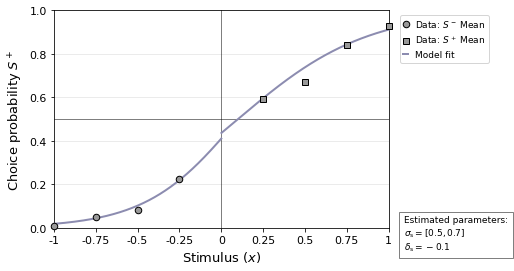

In [8]:
remeta.plot_psychometric_sim(data);

Note that the purple line is not a fit, but an (augmented) logistic function based on the true parameters. At zero, there is a discontinuity due the different noise parameters for stimulus > 0 and stimulus < 0. Moreover, the curve is shifted towards a preference for the negative stimulus category ($S^-$) due to the negative bias parameter ($S^-$ and $S^+$ are the two stimulus categories).

Next, we plot the relationship between stimulus intensity and confidence:

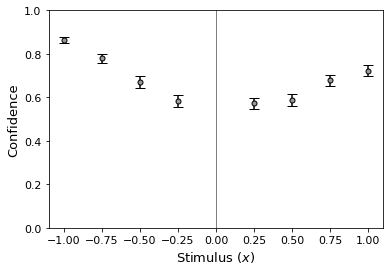

In [9]:
remeta.plot_confidence_sim(data);

We can see that the confidence slope for negative stimuli is a bit steeper. This is because we had introduced an assymmetry in the type 1 noise between the positive and the negative stimulus category. Since we further assume an observer that reports probability correct based on an estimate of type 1 noise, confidence appears more 'sensitive' for the negative stimulus category (remember that we set _lower_ type 1 noise for the stimulus category $S^-$ relative to the stimulus category $S^+$).

#### Model fit
We now need to create an instance of ReMeta. Note that for illustratory purposes we pass the true parameters to the configuration as well, for later comparison.

In [10]:
cfg.true_params = params_true
rem = remeta.ReMeta(cfg=cfg)

Now, everything is in place to fit the model to the simulated data. The fit function takes three main arguments: the stimuli (in the range -1 to 1), the choices (coded as 0 and 1) and confidence ratings (normalized to the range 0..1).

In [11]:
rem.fit(data.stimuli, data.choices, data.confidence)


+++ Sensory level +++
Initial guess (neg. LL: 1358.51)
    [guess] noise_sens_0: 0.1
    [guess] noise_sens_1: 0.1
    [guess] bias_sens: 0
Performing local optimization
    [final] noise_sens: [0.501, 0.682] (true: [0.5, 0.7])
    [final] bias_sens: -0.133 (true: -0.1)
Final neg. LL: 384.16
Neg. LL using true params: 384.57
Total fitting time: 0.36 secs

+++ Metacognitive level +++
Initial guess (neg. LL: 1838.20)
    [guess] noise_meta: 0.2
    [guess] evidence_bias_mult_meta: 1
    [guess] evidence_bias_add_meta: 0
Grid search activated (grid size = 300)
    [grid] noise_meta: 0.15
    [grid] evidence_bias_mult_meta: 1.7
    [grid] evidence_bias_add_meta: -0.2
Grid neg. LL: 1763.5
Grid runtime: 8.43 secs
Performing local optimization
    [final] noise_meta: 0.111 (true: 0.1)
    [final] evidence_bias_mult_meta: 1.37 (true: 1.3)
    [final] evidence_bias_add_meta: -0.105 (true: -0.1)
Final neg. LL: 1758.73
Neg. LL using true params: 1759.65
Total fitting time: 9.8 secs


#### Inspecting the model fit

Obtain the fitting result:

In [12]:
result = rem.summary()

The parameters are stored in the attribute `model`. We've seen the estimated parameters already printed above, but they are also stored in the result object:

In [13]:
for k, v in result.model.params_sens.items():
    print(f'{k}: {v}')

noise_sens: [0.5014270837344552, 0.6824963227217791]
bias_sens: -0.13345246817251966


Given that the original parameter were `noise_sens=[0.5, 0.7]` and `bias_sens=-0.1`, this is not too bad. We have recovered the original parameters to some approximation. Nevertheless, the fitted parameters do not _exactly_ match our generative parameters. Since we passed the true parameters, the result object allows us to check whether this is because the optimization routine did not find the global minimum. We can find out by comparing the negative log likelihood of the true and the fitted parameters:

In [14]:
print(f"Negative log-likelihood of true sensory parameters: {result.model.evidence_sens['negll_true']:.2f}")
print(f"Negative log-likelihood of fitted sensory  parameters: {result.model.evidence_sens['negll']:.2f}")

Negative log-likelihood of true sensory parameters: 384.57
Negative log-likelihood of fitted sensory  parameters: 384.16


The negative log-likelihood is smaller for the fitted parameters, i.e. the likelihood is higher for the fitted than the true parameters. We can thus be confident in the obtained parameters.

Next, we take a look at the metacognitive parameters:

In [15]:
for k, v in result.model.params_meta.items():
    print(f'{k}: {v}')

noise_meta: 0.1112721723809573
evidence_bias_mult_meta: 1.374323503306424
evidence_bias_add_meta: -0.10451653460239986


Note that our original parameters were `noise_meta=0.1`, `evidence_bias_mult_meta=1.3`, and `evidence_bias_add_meta=-0.1`, so this is close.

In [16]:
print(f"Negative log-likelihood of true metacognitive parameters: {result.model.evidence_meta['negll_true']:.2f}")
print(f"Negative log-likelihood of fitted metacognitive parameters: {result.model.evidence_meta['negll']:.2f}")

Negative log-likelihood of true metacognitive parameters: 1759.65
Negative log-likelihood of fitted metacognitive parameters: 1758.73


Again, the likelihhod is slightly better (i.e., lower) for the fitted parameters.

#### Visualization of the model fit

Having fit the model, we can now visualize confidence (based on the data and the fitted model) as a function of sensory decision values. For this purpose, a fitted `ReMeta` instance has a method called `plot_link_function()`:

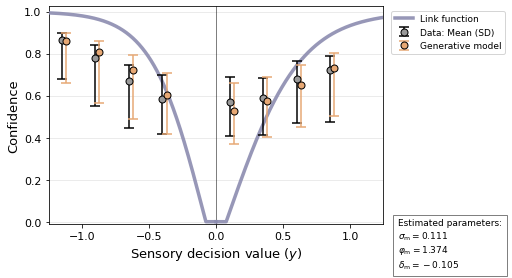

In [17]:
rem.plot_link_function()

The large overlap between data- and model-based confidence ratings is of course not surprising, since the data were generated with a model of identical architecture and similar parameters. Overlayed in purple is the link function that maps type 1 decision values to confidence. Note that the link function deviates from the simulated data and generative data, because it maps the theoretical relationship between evidence and confidence _in the absence of metacognitive noise_. In the range (-0.1 - 0.1), the link function is flat. This is caused by the negative additive evidence bias which introduces a kind of 'confidence threshold' below which sensory decision values are not metacognitively accessible.

Finally, we plot the distribution of confidence ratings from the generative model on top of the empirical confidence distribution by using a second plotting method `plot_confidence_dist()` provided by a fitted `ReMeta` instance.

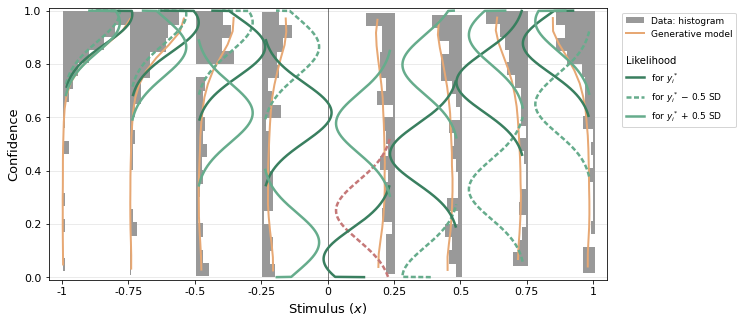

In [18]:
plt.figure(figsize=(10, 5))
rem.plot_confidence_dist()

The function separates both stimulus categories (positive and negative values) and the stimulus difficulty levels (here centered at ±0.25, ±0.5, ±0.75, ±1). In addition, example likelihood distributions of confidence are shown for the mode of the type 1 decision value distribution and 0.5 standard deviations above and below the mode. The orange curve represents the generative confidence density of the fitted model. It closely fits the simulated data (grey histograms).